In [6]:
import os
import sys
import pickle

import math
from datetime import timezone, datetime

import joblib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [7]:
from timescaledb_util import TimeScaleDBUtil

# TimescaleDB用のユーティリティライブラリの設定
_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

In [8]:
# ドルバー読み込み用の関数
def load_dollarbar(table_str, from_str, to_str, fee):
    _sql = f"SELECT * FROM \"{table_str}\" WHERE datetime >= '{from_str}' AND datetime < '{to_str}' ORDER BY dollar_cumsum ASC"
    df = _dbutil.read_sql_query(sql = _sql)
    df['fee'] = fee
    df = df[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']]
    df.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']
    df = df.set_index("Datetime")    
    return df

# 全区間のドルバーの読み込みと保存
df = load_dollarbar('ftx_btc-perp_dollarbar_5000000', '2021-01-01 00:00:00.000+00', '2023-01-01 00:00:00.000+00', 0.02/100)

In [9]:
# Richmanbtcさんのチュートリアルから取った関数
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

def calc_buysell(df, pips = 1, atr_mux = 0.5, atr_range=14):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_range)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist
    df['sell_price'] = df['Close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['Low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['High'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

# Richmanbtcさんのチュートリアルから取った特徴量計算関数
def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    
    hilo = (high + low) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    
    # ドルバー由来の特徴量を追加
    df['TIME'] = df.index
    df['DELTA_TIME'] = df['TIME'].diff()
    df['DELTA_TIME'] = df['DELTA_TIME'].view(int) / 1_000_000_000 # 単位は秒
    df['DELTA_TIME_T-1'] = df['DELTA_TIME'].shift(1)
    df['DELTA_TIME_T-2'] = df['DELTA_TIME'].shift(2)
    df['DELTA_TIME_T-3'] = df['DELTA_TIME'].shift(3)
    df['DELTA_TIME_T-4'] = df['DELTA_TIME'].shift(4)
    df['DELTA_TIME_T-5'] = df['DELTA_TIME'].shift(5)
    df['DELTA_TIME_T-6'] = df['DELTA_TIME'].shift(6)
    df['DELTA_TIME_T-7'] = df['DELTA_TIME'].shift(7)
    df['DELTA_TIME_T-8'] = df['DELTA_TIME'].shift(8)
    df['DELTA_TIME_T-9'] = df['DELTA_TIME'].shift(9)
    
    df['DELTA_TIME_T-1/T'] = df['DELTA_TIME_T-1'] / df['DELTA_TIME']
    df['DELTA_TIME_T-2/T'] = df['DELTA_TIME_T-2'] / df['DELTA_TIME']
    df['DELTA_TIME_T-3/T'] = df['DELTA_TIME_T-3'] / df['DELTA_TIME']
    df['DELTA_TIME_T-4/T'] = df['DELTA_TIME_T-4'] / df['DELTA_TIME']
    df['DELTA_TIME_T-5/T'] = df['DELTA_TIME_T-5'] / df['DELTA_TIME']
    df['DELTA_TIME_T-6/T'] = df['DELTA_TIME_T-6'] / df['DELTA_TIME']
    df['DELTA_TIME_T-7/T'] = df['DELTA_TIME_T-7'] / df['DELTA_TIME']
    df['DELTA_TIME_T-8/T'] = df['DELTA_TIME_T-8'] / df['DELTA_TIME']
    df['DELTA_TIME_T-9/T'] = df['DELTA_TIME_T-9'] / df['DELTA_TIME']
    
    df['BUY_RATIO'] = df['dollar_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['BUY_RATIO_T-1'] = df['BUY_RATIO'].shift(1)
    df['BUY_RATIO_T-2'] = df['BUY_RATIO'].shift(2)
    df['BUY_RATIO_T-3'] = df['BUY_RATIO'].shift(3)
    df['BUY_RATIO_T-4'] = df['BUY_RATIO'].shift(4)
    df['BUY_RATIO_T-5'] = df['BUY_RATIO'].shift(5)
    df['BUY_RATIO_T-6'] = df['BUY_RATIO'].shift(6)
    df['BUY_RATIO_T-7'] = df['BUY_RATIO'].shift(7)
    df['BUY_RATIO_T-8'] = df['BUY_RATIO'].shift(8)
    df['BUY_RATIO_T-9'] = df['BUY_RATIO'].shift(9)

    df['SELL_RATIO'] = df['dollar_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['SELL_RATIO_T-1'] = df['SELL_RATIO'].shift(1)
    df['SELL_RATIO_T-2'] = df['SELL_RATIO'].shift(2)
    df['SELL_RATIO_T-3'] = df['SELL_RATIO'].shift(3)
    df['SELL_RATIO_T-4'] = df['SELL_RATIO'].shift(4)
    df['SELL_RATIO_T-5'] = df['SELL_RATIO'].shift(5)
    df['SELL_RATIO_T-6'] = df['SELL_RATIO'].shift(6)
    df['SELL_RATIO_T-7'] = df['SELL_RATIO'].shift(7)
    df['SELL_RATIO_T-8'] = df['SELL_RATIO'].shift(8)
    df['SELL_RATIO_T-9'] = df['SELL_RATIO'].shift(9)

    df['LIQUIDATION_BUY_RATIO'] = df['dollar_liquidation_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO_T-1'] = df['LIQUIDATION_BUY_RATIO'].shift(1)
    df['LIQUIDATION_BUY_RATIO_T-2'] = df['LIQUIDATION_BUY_RATIO'].shift(2)
    df['LIQUIDATION_BUY_RATIO_T-3'] = df['LIQUIDATION_BUY_RATIO'].shift(3)
    df['LIQUIDATION_BUY_RATIO_T-4'] = df['LIQUIDATION_BUY_RATIO'].shift(4)
    df['LIQUIDATION_BUY_RATIO_T-5'] = df['LIQUIDATION_BUY_RATIO'].shift(5)
    df['LIQUIDATION_BUY_RATIO_T-6'] = df['LIQUIDATION_BUY_RATIO'].shift(6)
    df['LIQUIDATION_BUY_RATIO_T-7'] = df['LIQUIDATION_BUY_RATIO'].shift(7)
    df['LIQUIDATION_BUY_RATIO_T-8'] = df['LIQUIDATION_BUY_RATIO'].shift(8)
    df['LIQUIDATION_BUY_RATIO_T-9'] = df['LIQUIDATION_BUY_RATIO'].shift(9)

    df['LIQUIDATION_SELL_RATIO'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_SELL_RATIO_T-1'] = df['LIQUIDATION_SELL_RATIO'].shift()
    df['LIQUIDATION_SELL_RATIO_T-2'] = df['LIQUIDATION_SELL_RATIO'].shift(2)
    df['LIQUIDATION_SELL_RATIO_T-3'] = df['LIQUIDATION_SELL_RATIO'].shift(3)
    df['LIQUIDATION_SELL_RATIO_T-4'] = df['LIQUIDATION_SELL_RATIO'].shift(4)
    df['LIQUIDATION_SELL_RATIO_T-5'] = df['LIQUIDATION_SELL_RATIO'].shift(5)
    df['LIQUIDATION_SELL_RATIO_T-6'] = df['LIQUIDATION_SELL_RATIO'].shift(6)
    df['LIQUIDATION_SELL_RATIO_T-7'] = df['LIQUIDATION_SELL_RATIO'].shift(7)
    df['LIQUIDATION_SELL_RATIO_T-8'] = df['LIQUIDATION_SELL_RATIO'].shift(8)
    df['LIQUIDATION_SELL_RATIO_T-9'] = df['LIQUIDATION_SELL_RATIO'].shift(9)
    
    return df.dropna()

/tmp/ipykernel_3071955/835920855.py:187: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SELL_RATIO_T-7'] = df['SELL_RATIO'].shift(7)
/tmp/ipykernel_3071955/835920855.py:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['SELL_RATIO_T-8'] = df['SELL_RATIO'].shift(8)
/tmp/ipykernel_3071955/835920855.py:189: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  T

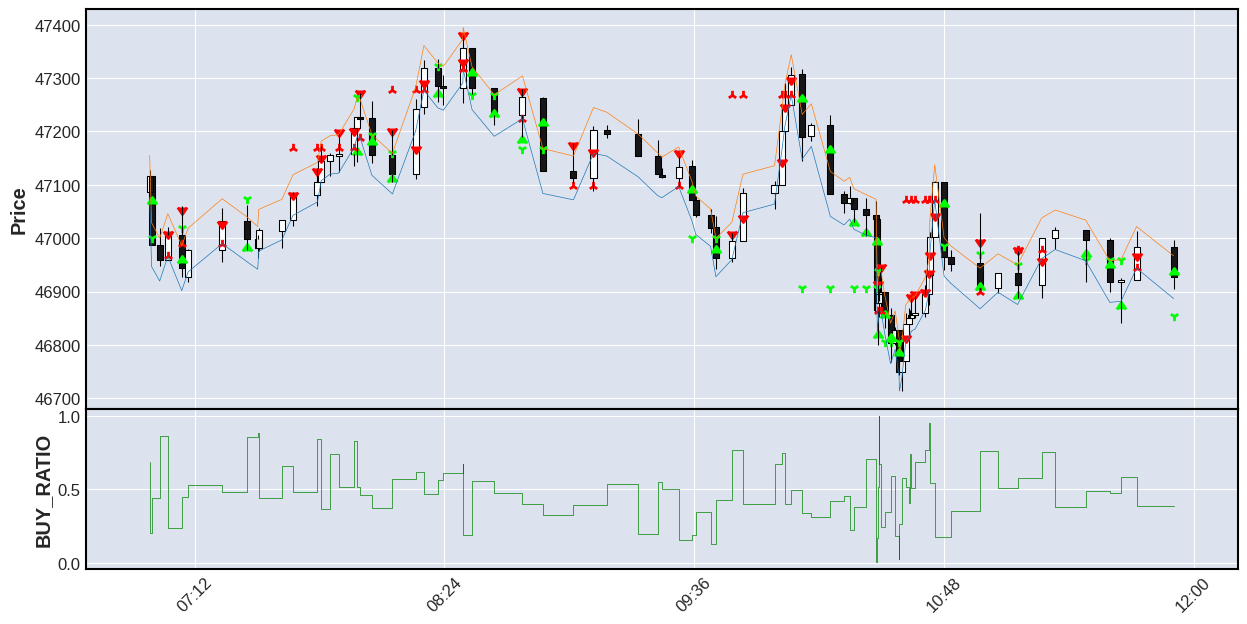

In [17]:
df_test_display = df[(df.index >= '2022-01-01 00:00:00+00') & (df.index < '2022-01-01 12:00:00+00')].copy()
df_test_display = calc_features(df_test_display)
df_test_display = calc_buysell(df_test_display, pips = 1, atr_mux = 0.5).dropna()

extra_plot = []
extra_plot.append(mpf.make_addplot(df_test_display[['buy_price','sell_price']], width=0.5))

series_buy_price = df_test_display['buy_executed'] * df_test_display['buy_price']
series_buy_price.replace(0.0, np.nan, inplace=True)
extra_plot.append(mpf.make_addplot(series_buy_price.shift(), type='scatter', markersize=45, marker=6, color='lime'))

series_sell_price = df_test_display['sell_executed'] * df_test_display['sell_price']
series_sell_price.replace(0.0, np.nan, inplace=True)
extra_plot.append(mpf.make_addplot(series_sell_price.shift(), type='scatter', markersize=45, marker=7, color='red'))

series_fep_sell_price = df_test_display['buy_executed'] * df_test_display['sell_fep'].shift(-1)
series_fep_sell_price.replace(0.0, np.nan, inplace=True)
extra_plot.append(mpf.make_addplot(series_fep_sell_price.shift(), type='scatter', markersize=45, marker='1', color='lime'))

series_fep_buy_price = df_test_display['sell_executed'] * df_test_display['buy_fep'].shift(-1)
series_fep_buy_price.replace(0.0, np.nan, inplace=True)
extra_plot.append(mpf.make_addplot(series_fep_buy_price.shift(), type='scatter', markersize=45, marker='2', color='red'))

extra_plot.append(mpf.make_addplot(df_test_display['BUY_RATIO'], panel='lower', color='green', ylabel='BUY_RATIO', type='step', width=0.5))

mpf.plot(df_test_display, type="candle", show_nontrading=True, addplot=extra_plot, figsize=(16, 8))